In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind
from IPython.display import display

In [2]:
# Load data
df = pd.read_csv("post_pandemic_remote_work_health_impact_2025.csv")
df.head()

,Survey_Date,Age,Gender,Region,Industry,Job_Role,Work_Arrangement,Hours_Per_Week,Mental_Health_Status,Burnout_Level,Work_Life_Balance_Score,Physical_Health_Issues,Social_Isolation_Score,Salary_Range
0,2025-06-01,27,Female,Asia,Professional Services,Data Analyst,Onsite,64,Stress Disorder,High,3,Shoulder Pain; Neck Pain,2,$40K-60K
1,2025-06-01,37,Female,Asia,Professional Services,Data Analyst,Onsite,37,Stress Disorder,High,4,Back Pain,2,$80K-100K
2,2025-06-01,32,Female,Africa,Education,Business Analyst,Onsite,36,ADHD,High,3,Shoulder Pain; Eye Strain,2,$80K-100K
3,2025-06-01,40,Female,Europe,Education,Data Analyst,Onsite,63,ADHD,Medium,1,Shoulder Pain; Eye Strain,2,$60K-80K
4,2025-06-01,30,Male,South America,Manufacturing,DevOps Engineer,Hybrid,65,NaN,Medium,5,NaN,4,$60K-80K


In [3]:
# Filter to include only remote workers
df_remote = df[df["Work_Arrangement"] == "Remote"].copy()
df_remote.head()

,Survey_Date,Age,Gender,Region,Industry,Job_Role,Work_Arrangement,Hours_Per_Week,Mental_Health_Status,Burnout_Level,Work_Life_Balance_Score,Physical_Health_Issues,Social_Isolation_Score,Salary_Range
8,2025-06-01,30,Female,South America,Technology,Software Engineer,Remote,47,Anxiety,Medium,2,Neck Pain,4,$60K-80K
11,2025-06-01,64,Male,North America,Technology,Business Analyst,Remote,35,ADHD,Medium,3,Eye Strain; Wrist Pain,4,$40K-60K
13,2025-06-01,37,Male,Europe,Finance,UX Designer,Remote,59,Anxiety,High,5,Back Pain; Shoulder Pain; Wrist Pain,5,$60K-80K
14,2025-06-01,50,Male,Europe,Professional Services,Social Media Manager,Remote,64,Burnout,Medium,1,NaN,4,$60K-80K
19,2025-06-01,27,Female,Africa,Healthcare,Account Manager,Remote,43,NaN,Medium,1,NaN,4,$80K-100K


In [4]:
# Check for duplicates
print("Duplicates:", df_remote.duplicated().sum())

Duplicates: 0


In [5]:
# Quick look at nulls
print("Missing values per column:")
null_counts = df_remote.isnull().sum().reset_index()
null_counts.columns = ["Column", "Null Values"]
display(null_counts)

Missing values per column:


,Column,Null Values
0,Survey_Date,0
1,Age,0
2,Gender,0
3,Region,0
4,Industry,0
5,Job_Role,0
6,Work_Arrangement,0
7,Hours_Per_Week,0
8,Mental_Health_Status,163
9,Burnout_Level,0


In [6]:
# Take care of columns with missing values
df_remote["Mental_Health_Status"] = df_remote["Mental_Health_Status"].fillna("None")
df_remote["Physical_Health_Issues"] = df_remote["Physical_Health_Issues"].fillna("None")

null_counts = df_remote.isnull().sum().reset_index()
null_counts.columns = ["Column", "Null Values"]
display(null_counts)

,Column,Null Values
0,Survey_Date,0
1,Age,0
2,Gender,0
3,Region,0
4,Industry,0
5,Job_Role,0
6,Work_Arrangement,0
7,Hours_Per_Week,0
8,Mental_Health_Status,0
9,Burnout_Level,0


In [7]:
# Get all issues in Physical_Health_Issues, split by ;
issues = set(
    df_remote["Physical_Health_Issues"]
    .str.split(";")
    .apply(lambda x: [issue.strip() for issue in x if issue.strip()])
    .explode()
    .dropna()
    .unique()
)
issues.remove("None")
issues.add("No Physical Health Issues")

# One-hot encode selected health issues for remote workers, using True/False
df_remote["Physical_Health_Issues"] = (
    df_remote["Physical_Health_Issues"]
    .replace("None", "No Physical Health Issues")
    .astype(str)
)
for issue in issues:
    colname = issue.replace(" ", "_")
    df_remote[colname] = df_remote["Physical_Health_Issues"].apply(lambda x: issue in x)

In [8]:
# Categorical summaries (using display for better output)
categorical_cols = {
    "Gender",
    "Region",
    "Industry",
    "Job_Role",
    "Work_Arrangement",
    "Mental_Health_Status",
    "Burnout_Level",
    "Salary_Range",
}.union([issue.replace(" ", "_") for issue in issues])
numericals_cols = (
    set(df_remote.columns)
    .difference(categorical_cols)
    .difference({"Physical_Health_Issues", "Survey_Date"})
)

df_categorical = df_remote[list(categorical_cols)]
df_numerical = df_remote[list(numericals_cols)]

In [9]:
# Creating a dictionary to store the labeled dataframes
categorical_summary_dfs = {
    col: pd.concat(
        [
            df_categorical[col].value_counts(normalize=True),
            df_categorical[col].value_counts(),
        ],
        axis=1,
        keys=["proportion", "count"],
    )
    for col in df_categorical
}

# Concatenating along axis=0 with keys as column labels
categorical_summary_df = pd.concat(categorical_summary_dfs, axis=0)

# Displaying the dataframe
pd.set_option("display.max_rows", None)
display(categorical_summary_df)
pd.reset_option("display.max_rows")

proportion  count
Shoulder_Pain             False                           0.534014    314
                          True                            0.465986    274
Burnout_Level             High                            0.464286    273
                          Medium                          0.397959    234
                          Low                             0.137755     81
Mental_Health_Status      None                            0.277211    163
                          PTSD                            0.132653     78
                          Anxiety                         0.127551     75
                          ADHD                            0.120748     71
                          Stress Disorder                 0.120748     71
                          Depression                      0.113946     67
                          Burnout                         0.107143     63
Job_Role                  Operations Manager              0.052721     31
                          Research Scientist              0.052721     31
                          Quality Assurance               0.052721     31
                          Data Analyst                    0.051020     30
                          Product Manager                 0.049320     29
                          IT Support                      0.047619     28
                          Data Scientist                  0.047619     28
                          Social Media Manager            0.044218     26
                          Project Manager                 0.044218     26
                          Customer Service Manager        0.044218     26
                          UX Designer                     0.042517     25
                          Software Engineer               0.040816     24
                          Technical Writer                0.040816     24
                          Digital Marketing Specialist    0.040816     24
                          Consultant                      0.039116     23
                          Content Writer                  0.039116     23
                          Business Analyst                0.039116     23
                          HR Manager                      0.039116     23
                          Sales Representative            0.037415     22
                          Executive Assistant             0.035714     21
                          Financial Analyst               0.034014     20
                          DevOps Engineer                 0.034014     20
                          Account Manager                 0.028912     17
                          Marketing Specialist            0.022109     13
Salary_Range              $60K-80K                        0.304422    179
                          $80K-100K                       0.294218    173
                          $40K-60K                        0.205782    121
                          $100K-120K                      0.129252     76
                          $120K+                          0.066327     39
Wrist_Pain                False                           0.833333    490
                          True                            0.166667     98
Industry                  Technology                      0.340136    200
                          Professional Services           0.161565     95
                          Manufacturing                   0.153061     90
                          Finance                         0.090136     53
                          Education                       0.078231     46
                          Healthcare                      0.052721     31
                          Customer Service                0.045918     27
                          Retail                          0.045918     27
                          Marketing                       0.032313     19
Neck_Pain                 False                           0.709184    417
                          True                            0.

In [10]:
# Outlier checks
df_outliers = pd.DataFrame(
    {
        "Age < 18": df_numerical["Age"] < 18,
        "Age > 65": df_numerical["Age"] > 65,
        "Hours_Per_Week < 0": df_numerical["Hours_Per_Week"] < 0,
        "Hours_Per_Week > 80": df_numerical["Hours_Per_Week"] > 80,
    }
)
df_outliers = df_outliers.sum().reset_index()
df_outliers.columns = ["Condition", "Count"]
display(df_outliers)

,Condition,Count
0,Age < 18,0
1,Age > 65,0
2,Hours_Per_Week < 0,0
3,Hours_Per_Week > 80,0


## Exploratory Data Analysis (EDA) on Burnout in Remote Work

In [11]:
# Summary statistics for all numeric columns
display(df_numerical.describe())

# describe numerical columns based on Burnout level
for col in numericals_cols:
    print(f"Summary statistics for {col} by Burnout Level:")
    display(df_numerical.groupby(df_remote["Burnout_Level"])[col].describe())

,Hours_Per_Week,Work_Life_Balance_Score,Social_Isolation_Score,Age
count,588.000000,588.000000,588.000000,588.000000
mean,49.872449,2.993197,3.496599,44.284014
std,8.875001,1.207566,1.147543,12.485738
min,35.000000,1.000000,1.000000,22.000000
25%,42.750000,2.000000,3.000000,34.000000
50%,50.000000,3.000000,4.000000,45.000000
75%,57.000000,4.000000,4.000000,55.000000
max,65.000000,5.000000,5.000000,65.000000


Summary statistics for Hours_Per_Week by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,49.769231,9.085068,35.0,42.0,50.0,57.0,65.0
Low,81.0,48.950617,8.549709,35.0,42.0,49.0,56.0,65.0
Medium,234.0,50.311966,8.745379,35.0,43.0,50.0,58.0,65.0


Summary statistics for Work_Life_Balance_Score by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,3.036630,1.224195,1.0,2.0,3.0,4.0,5.0
Low,81.0,3.000000,1.214496,1.0,2.0,3.0,4.0,5.0
Medium,234.0,2.940171,1.188577,1.0,2.0,3.0,4.0,5.0


Summary statistics for Social_Isolation_Score by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,3.446886,1.174922,1.0,3.0,4.0,4.0,5.0
Low,81.0,3.530864,1.119000,1.0,3.0,4.0,4.0,5.0
Medium,234.0,3.542735,1.127252,1.0,3.0,4.0,4.0,5.0


Summary statistics for Age by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,44.498168,12.495330,22.0,34.0,45.0,56.0,65.0
Low,81.0,44.296296,12.578200,23.0,35.0,45.0,54.0,65.0
Medium,234.0,44.029915,12.491506,22.0,33.0,45.0,54.0,65.0


## Visualizations

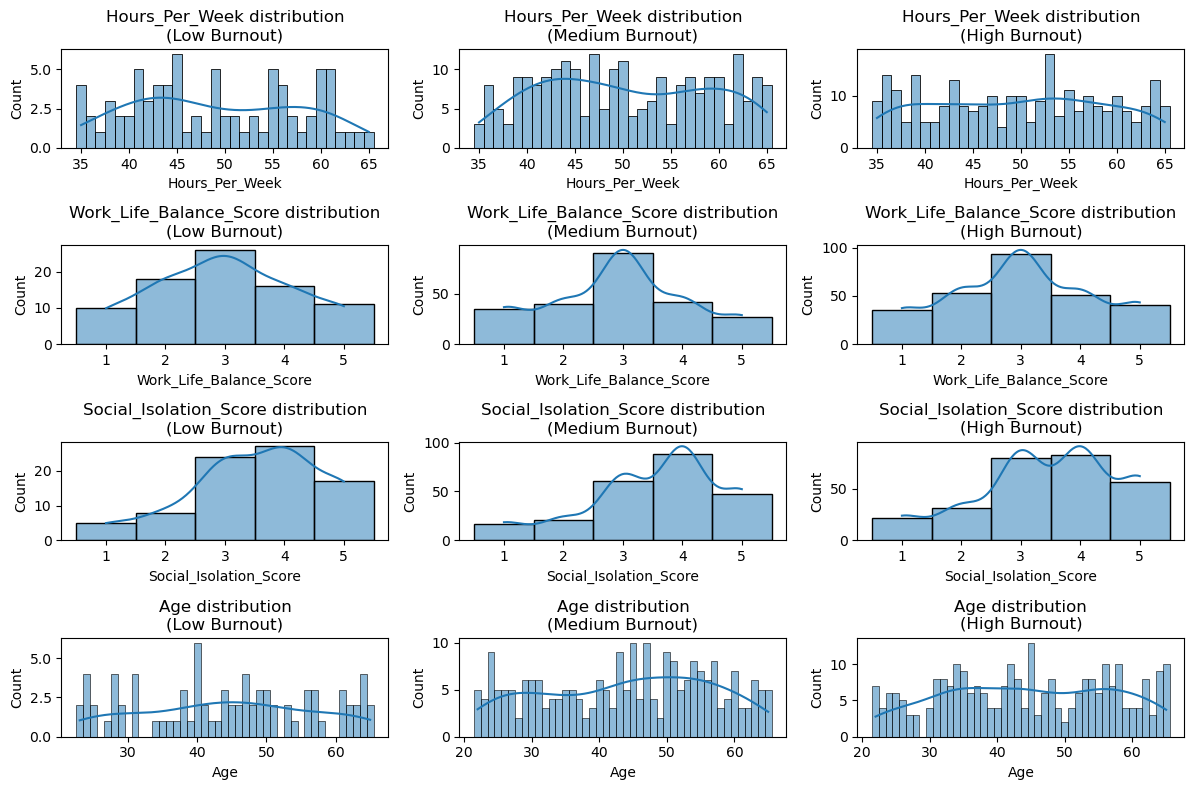

In [12]:
plt.figure(figsize=(12, 8))
# plot distributions of each column for each burnout level for all numerical columns
# The grid size is i x 3 where i is the number of numerical columns
for i, col in enumerate(df_numerical.columns, 1):
    start_index = (i - 1) * 3 + 1
    plt.subplot(len(df_numerical.columns), 3, start_index)
    # plot distributions of each column for each burnout level
    sns.histplot(
        df_numerical[col].loc[df_remote["Burnout_Level"] == "Low"],
        kde=True,
        discrete=True,
    )
    plt.title(f"{col} distribution\n(Low Burnout)")
    plt.subplot(len(df_numerical.columns), 3, start_index + 1)
    sns.histplot(
        df_numerical[col].loc[df_remote["Burnout_Level"] == "Medium"],
        kde=True,
        discrete=True,
    )
    plt.title(f"{col} distribution\n(Medium Burnout)")
    plt.subplot(len(df_numerical.columns), 3, start_index + 2)
    sns.histplot(
        df_numerical[col].loc[df_remote["Burnout_Level"] == "High"],
        kde=True,
        discrete=True,
    )
    plt.title(f"{col} distribution\n(High Burnout)")
plt.tight_layout()
plt.show()

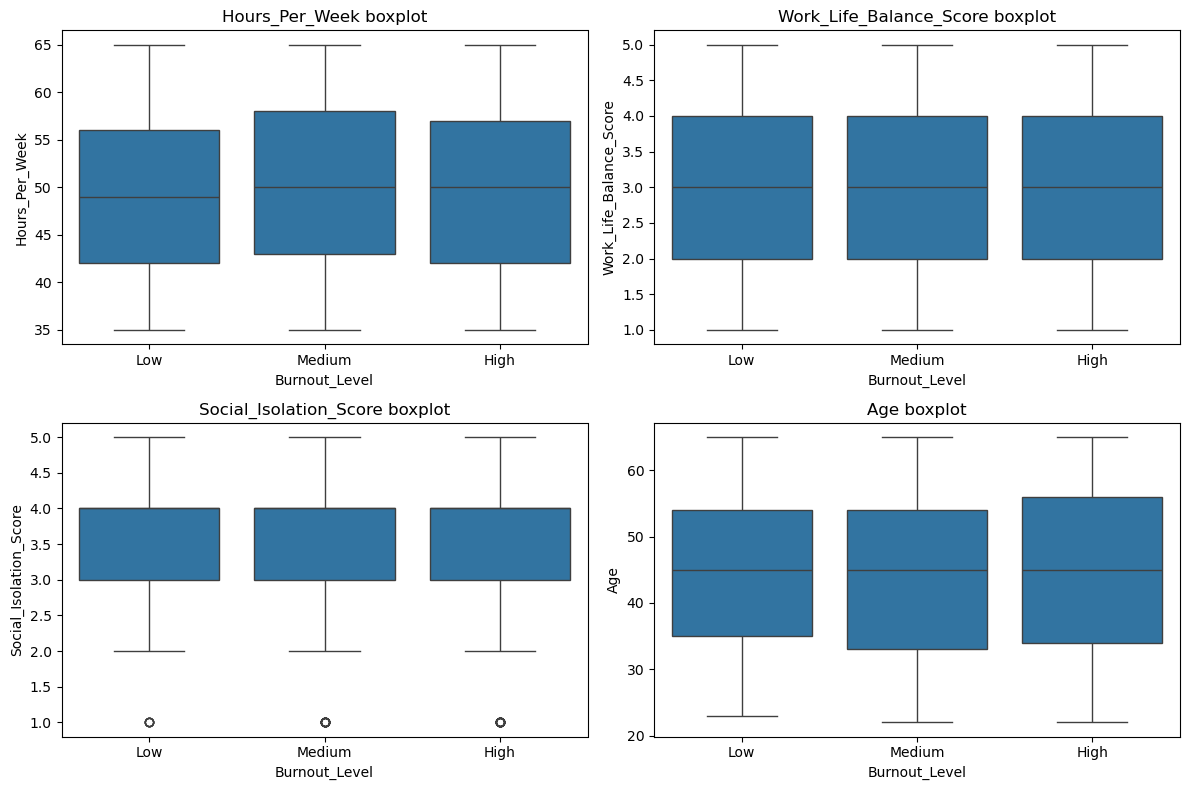

In [13]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df_numerical.columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(
        x=df_categorical["Burnout_Level"],
        y=df_numerical[col],
        order=["Low", "Medium", "High"],
    )
    plt.title(f"{col} boxplot")
plt.tight_layout()
plt.show()

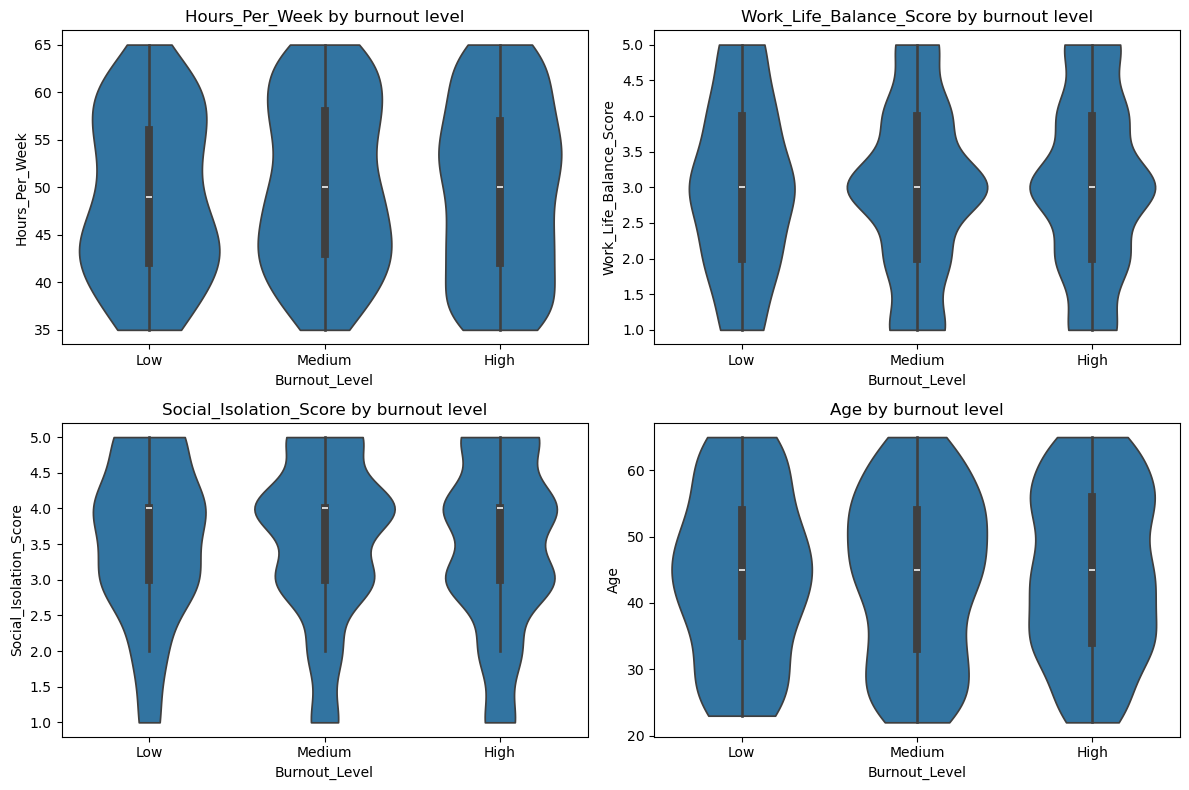

In [14]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df_numerical.columns, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(
        x="Burnout_Level",
        y=col,
        data=pd.concat([df_categorical["Burnout_Level"], df_numerical], axis=1),
        inner="box",
        cut=0,
        order=["Low", "Medium", "High"],
    )
    plt.title(f"{col} by burnout level")
plt.tight_layout()
plt.show()

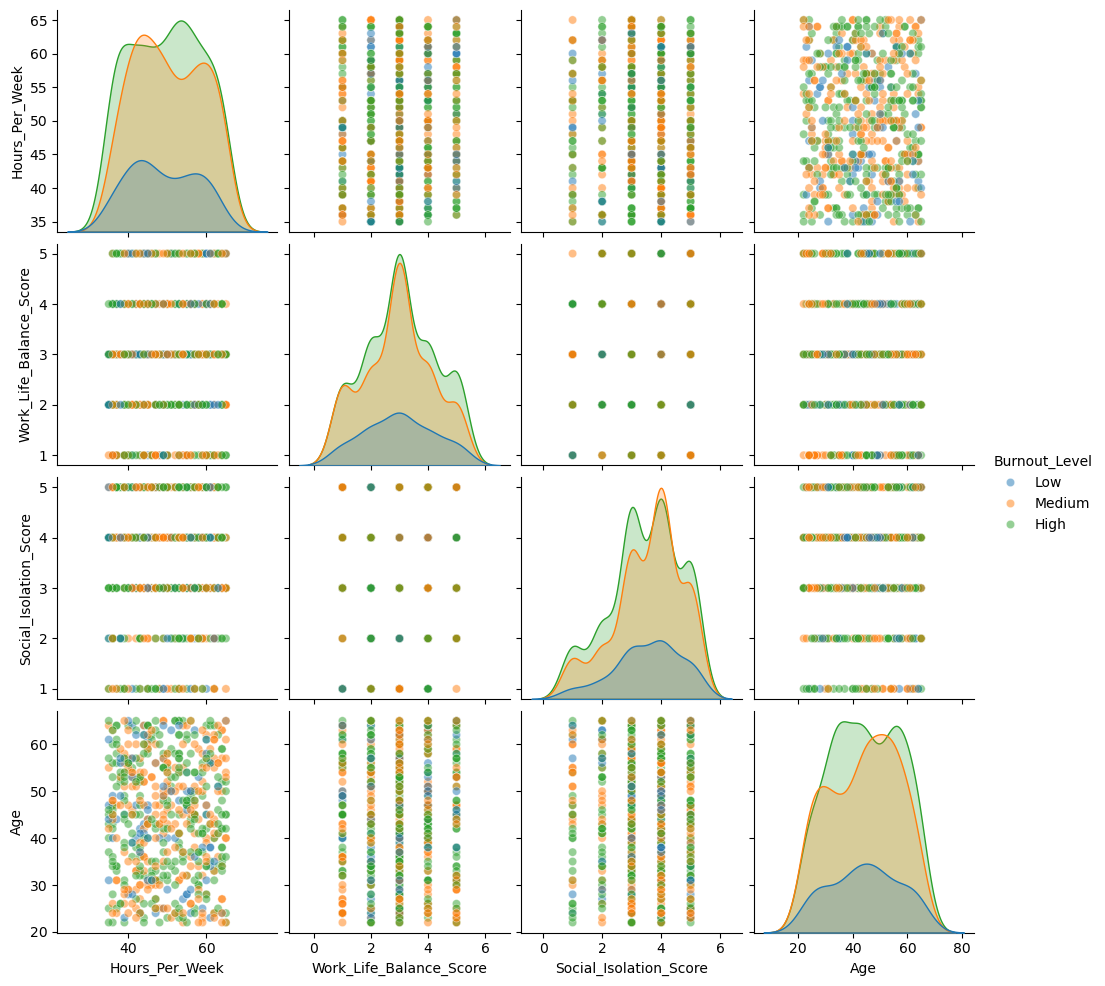

In [15]:
sns.pairplot(
    df_remote,
    vars=df_numerical.columns,
    hue="Burnout_Level",
    diag_kind="kde",
    plot_kws={"alpha": 0.5},
    height=2.5,
    hue_order=["Low", "Medium", "High"],
)
plt.show()

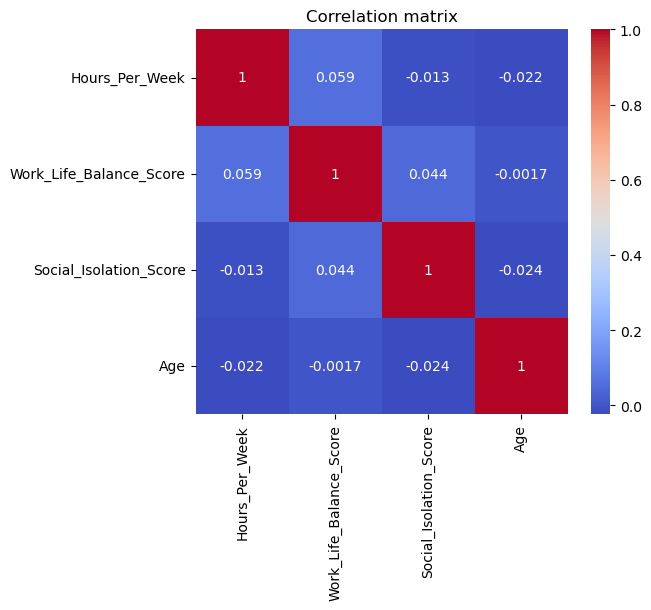

In [16]:
plt.figure(figsize=(6, 5))
corr = df_numerical.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

## Significance Testing

In [17]:
print("T-test for Low vs Medium and High Burnout Levels")
ttest_ind_results = []
for col in numericals_cols:
    group1 = df_remote[df_remote["Burnout_Level"] != "Low"][col]
    group0 = df_remote[df_remote["Burnout_Level"] == "Low"][col]
    t_stat, p_val = ttest_ind(group1, group0, equal_var=False)
    ttest_ind_results.append(
        {
            "Column": col,
            "T-statistic": t_stat,
            "P-value": p_val,
            "Conclusion": (
                "Significant difference"
                if p_val < 0.05
                else "No significant difference"
            ),
        }
    )
ttest_ind_results_df = pd.DataFrame(ttest_ind_results)
display(ttest_ind_results_df)

T-test for Low vs Medium and High Burnout Levels


,Column,T-statistic,P-value,Conclusion
0,Hours_Per_Week,1.038625,0.301262,No significant difference
1,Work_Life_Balance_Score,-0.054331,0.956773,No significant difference
2,Social_Isolation_Score,-0.295540,0.768144,No significant difference
3,Age,-0.009474,0.992458,No significant difference


In [18]:
print("T-test for Low vs High Burnout Levels")
ttest_ind_results = []
for col in numericals_cols:
    group1 = df_remote[df_remote["Burnout_Level"] == "High"][col]
    group0 = df_remote[df_remote["Burnout_Level"] == "Low"][col]
    t_stat, p_val = ttest_ind(group1, group0, equal_var=False)
    ttest_ind_results.append(
        {
            "Column": col,
            "T-statistic": t_stat,
            "P-value": p_val,
            "Conclusion": (
                "Significant difference"
                if p_val < 0.05
                else "No significant difference"
            ),
        }
    )
ttest_ind_results_df = pd.DataFrame(ttest_ind_results)
display(ttest_ind_results_df)

T-test for Low vs High Burnout Levels


,Column,T-statistic,P-value,Conclusion
0,Hours_Per_Week,0.745805,0.457053,No significant difference
1,Work_Life_Balance_Score,0.237940,0.812296,No significant difference
2,Social_Isolation_Score,-0.586307,0.558637,No significant difference
3,Age,0.127038,0.899106,No significant difference


In [19]:
chi2_results = []
for col in categorical_cols:
    if col == "Burnout_Level":
        continue
    contingency_table = pd.crosstab(df_remote[col], df_remote["Burnout_Level"])
    chi2_stat, p_val_chi2, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append(
        {
            "Column": col,
            "Chi-squared Statistic": chi2_stat,
            "P-value": p_val_chi2,
            "Conclusion": (
                "Association exists" if p_val_chi2 < 0.05 else "No association"
            ),
        }
    )
chi2_results_df = pd.DataFrame(chi2_results)
display(chi2_results_df)

,Column,Chi-squared Statistic,P-value,Conclusion
0,Shoulder_Pain,0.618908,0.733848,No association
1,Mental_Health_Status,15.017915,0.240458,No association
2,Job_Role,40.048894,0.718729,No association
3,Salary_Range,4.090046,0.848909,No association
4,Wrist_Pain,10.028816,0.006642,Association exists
5,Industry,22.703213,0.121902,No association
6,Neck_Pain,0.582931,0.747168,No association
7,Region,12.173529,0.273611,No association
8,Eye_Strain,1.726253,0.421841,No association
9,No_Physical_Health_Issues,1.475573,0.478171,No association
